# Naive Deep Q-learning

This notebook implements a naive deep Q-learning algorithm in combination with a neural network. The neural network's objective is to approximate the optimal Q-value for each state-action pair in our environment. 

We use a neural network with two linear layers that take a low-level representation of the environment as input and output the Q-values, corresponding to the actions an agent can take from that state. Stochastic Gradient Descent (SGD) will be used as an optimizer with mean square error as a loss function. As for the action selection strategy, we choice epsilon-decay, where we decrease epsilon by a small amount after each new episode. The learning rate will be set to 0.001. This naive deep Q-learning algorithm's overall goal is to serve as a benchmark for further improvement, and thus hyperparameter tuning will not be considered in this section. 

We test our algorithms using the cart-and-pole environment from the OpenAI Gym environment, where our goal is to balance a flagpole on a cart as long as possible. A reward of + 1 is given to the agent for every timestep that the pole remains upright. The goal of the agent to maximize the discounted reward over a continuous-time span [OpenAI Gym]. 

**References:**
- https://gym.openai.com/envs/CartPole-v0/
- https://github.com/philtabor/Deep-Q-Learning-Paper-To-Code

## Import Libraries

In [28]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T

import gym
import random
import numpy as np

from ipynb.fs.full.Plotting import *
import matplotlib.pyplot as plt

In [29]:
random.seed(2021)

## Naive Deep Q-network

In [30]:
class LinearDeepQNetwork(nn.Module):
    def __init__(self, observation_space, action_space, learning_rate):
        super(LinearDeepQNetwork, self).__init__()
        
        self.observation_space = observation_space
        self.action_space = action_space
        self.learning_rate = learning_rate
        
        self.fc1 = nn.Linear(*self.observation_space, 128)
        self.fc2 = nn.Linear(128, self.action_space)
        
        self.optimizer = optim.SGD(self.parameters(), lr = self.learning_rate)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.loss = nn.MSELoss()
        self.to(self.device)
        
    def forward(self, observation):
        layer1 = F.relu(self.fc1(observation))
        actions = self.fc2(layer1)
        
        return actions  

## Reinforcement Learning Agent

In [31]:
class Agent():
    def __init__(self, observation_space, action_space, learning_rate = 0.001, discount_rate = 0.99, exploration_rate = 1.0,
                 max_exploration_rate = 1, min_exploration_rate = 0.01,  exploration_decay_rate = 0.001):
        
        self.episode = 0
        
        self.observation_space = observation_space
        self.action_space = action_space
        
        self.learning_rate = learning_rate
        self.discount_rate = discount_rate
        
        self.exploration_rate = exploration_rate
        self.max_exploration_rate = max_exploration_rate
        self.min_exploration_rate = min_exploration_rate
        self.exploration_decay_rate = exploration_decay_rate
        
        self.policy_network = LinearDeepQNetwork(self.observation_space, self.action_space, self.learning_rate)
        
    def choice_action(self, observation):
        exploration_rate_threshold = np.random.random()
        if exploration_rate_threshold > self.exploration_rate:
            observation = T.tensor(observation, dtype = T.float).to(self.policy_network.device)
            actions = self.policy_network.forward(observation) # Q-values for action in state.
            action = T.argmax(actions).item() # Best Q-value for action in state.
        else:
            action = np.random.choice(self.action_space) # Random action.
            
        return action
    
    def decrease_exploration_rate(self):
        self.exploration_rate = self.min_exploration_rate + \
            (self.max_exploration_rate - self.min_exploration_rate) * np.exp(- self.exploration_decay_rate * self.episode)
        self.episode += 1

    def learn(self, observation, action, reward, next_observation):
        # Set gradient to zero.
        self.policy_network.optimizer.zero_grad()
        
        # Convert to tensors.
        observation = T.tensor(observation, dtype = T.float).to(self.policy_network.device)
        action = T.tensor(action).to(self.policy_network.device)
        reward = T.tensor(reward).to(self.policy_network.device)
        next_observation = T.tensor(next_observation, dtype = T.float).to(self.policy_network.device)
        
        # Calculate loss using Bellman equation.
        q_pred = self.policy_network.forward(observation)[action]
        q_next = self.policy_network.forward(next_observation).max()
        q_target = reward + self.exploration_rate * q_next
        loss = self.policy_network.loss(q_target, q_pred).to(self.policy_network.device)
        
        # Optimizer in action.
        loss.backward()
        self.policy_network.optimizer.step()

## Main Program

In [32]:
step = 0
episodes = 10000

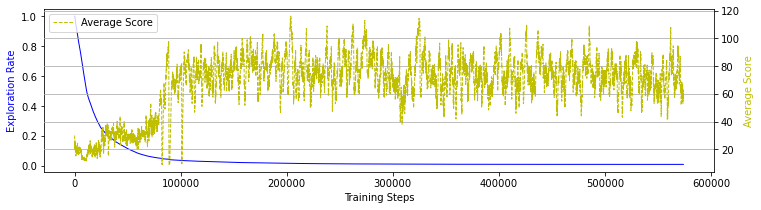

In [33]:
env = gym.make('CartPole-v0')

observation_space = env.observation_space.shape
action_space = env.action_space.n
agent = Agent(observation_space,  action_space)

scores, exploration_rate_history, steps = [], [], []

for i in range(episodes):
    observation = env.reset()
    done = False
    score = 0.0
    
    while not done:
        action = agent.choice_action(observation)
        next_observation, reward, done, _ = env.step(action)
        agent.learn(observation, action, reward, next_observation)
        observation = next_observation
        score += reward
        step += 1
        
    scores.append(score)
    steps.append(step)
    exploration_rate_history.append(agent.exploration_rate)
    agent.decrease_exploration_rate()    

plot_learning_curve(steps, scores, exploration_rate_history)

Overall the average score tends to go up over time in tandem. As time goes on, the agent's score slowly increases before finally reaching its first peak. After reaching a peak, it catastrophically drops back down to a minimum. This process reoccurs several times. Our naive implementation, as applied to a continuous state-space, does not achieve fast learning. This is due to several reasons, as explained in (Mnih et al., 2015).

Reason one is that we only learn from a single example. The agent sees many thousands of steps, and this experience is discarded each time. One could claim that learning is embodied by the evolution of our neural network's weights, but this is not entirely accurate. A neural network approximates a function in a high-dimensional space. The number of dimensions is the product of the number of neurons in each layer. Each time we start a new episode, we start in a random state in this high-dimensional space. As long as we keep epsilon large, we can explore this high-dimensional space really efficiently. This is because the max Q(s', a') action will tend to favor parts of the parameter space that look familiar. As we gradually reduce epsilon, our transitions become smaller, resulting in being stuck in a local minimum. The second problem occurs while using the same network to evaluate the maximum Q-value action and choose that maximum action. This gets updated at every step, so it appears as we chaise our own tail. The max Q(s', a') term has the potential to bias our agent. We evaluate the Q-function with respect to the max Q(s', a') term, so this is the definition of bias.

As a summary, our network took an input vector from the cart-and-pole environment and passed it through some hidden layers to generate each action's values for that particular state. We only used linear layers because the cart-and-pole example uses simple observations, but this would always be the case.